### Reacher-v2 Environment with CNN

In [1]:
import gym
env = gym.make('Reacher-v101')
state = env.reset()

Creating offscreen glfw


In [2]:
env.observation_space

Box(49152,)

In [3]:
env.observation_space.shape

(49152,)

In [ ]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense, Conv2D, Flatten
from keras.optimizers import Adam
from keras.models import Sequential, load_model
import os
from IPython.core.debugger import set_trace

EPISODES = 1000 #Maximum number of episodes

#DQN Agent for the reacher-v2
#Q function approximation with NN, experience replay, and target network
class DQNAgent:
    #Constructor for the agent (invoked when DQN is first called in main)
    def __init__(self, state_size, action_space):
        self.check_solve = False	#If True, stop if you satisfy solution condition
        self.render = False #If you want to see Cartpole learning, then change to True
        self.action_space = action_space
        #Get size of state and action
        self.state_size = state_size
        self.action_size = len(action_space)
        

################################################################################
################################################################################
        #Set hyper parameters for the DQN. Do not adjust those labeled as Fixed.
        self.discount_factor = 0.95
        self.learning_rate = 0.005  # 0.005
        self.epsilon = 0.02 #Fixed
        self.batch_size = 32 #Fixed
        self.memory_size = 500000  # 1000
        self.train_start = 1000 #Fixed
        self.target_update_frequency = 1
################################################################################
################################################################################

        #Number of test states for Q value plots
        self.test_state_no =10000 # 10000

        #Create memory buffer using deque
        self.memory = deque(maxlen=self.memory_size)

        #Create main network and target network (using build_model defined below)
        self.model = self.build_model()
        self.target_model = self.build_model()

        #Initialize target network
        self.update_target_model()

    #Approximate Q function using Neural Network
    #State is the input and the Q Values are the output.
###############################################################################
###############################################################################
        #Edit the Neural Network model here
        #Tip: Consult https://keras.io/getting-started/sequential-model-guide/
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        #
        # self.model = Sequential()
        # self.model.add(Dense(16, input_shape=(observation_space,), activation="relu"))
        # self.model.add(Dense(16, activation="relu"))
        # self.model.add(Dense(self.action_space, activation="linear"))
        # self.model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
###############################################################################
###############################################################################
#     set_trace()
    #After some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Get action from model using epsilon-greedy policy
    def get_action(self, state):
###############################################################################
###############################################################################
        #Insert your e-greedy policy code here
        #Tip 1: Use the random package to generate a random action.
        #Tip 2: Use keras.model.predict() to compute Q-values from the state.
        if np.random.rand() <= self.epsilon:
            action =  random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            action =  np.argmax(q_value[0])
        # action = random.randrange(self.action_size)
        return action
###############################################################################
###############################################################################
    #Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #Add sample to the end of the list

    #Sample <s,a,r,s'> from replay memory
    def train_model(self):
        if len(self.memory) < self.train_start: #Do not train if not enough memory
            return
        batch_size = min(self.batch_size, len(self.memory)) #Train on at most as many samples as you have in memory
        mini_batch = random.sample(self.memory, batch_size) #Uniformly sample the memory buffer
        #Preallocate network and target network input matrices.
        update_input = np.zeros((batch_size, self.state_size)) #batch_size by state_size two-dimensional array (not matrix!)
        update_target = np.zeros((batch_size, self.state_size)) #Same as above, but used for the target network
        action, reward, done = [], [], [] #Empty arrays that will grow dynamically

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #Allocate s(i) to the network input array from iteration i in the batch
            action.append(mini_batch[i][1]) #Store a(i)
            reward.append(mini_batch[i][2]) #Store r(i)
            update_target[i] = mini_batch[i][3] #Allocate s'(i) for the target network array from iteration i in the batch
            done.append(mini_batch[i][4])  #Store done(i)

        target = self.model.predict(update_input) #Generate target values for training the inner loop network using the network model
        target_val = self.target_model.predict(update_target) #Generate the target values for training the outer loop target network
        #Q Learning: get maximum Q value at s' from target network
###############################################################################
###############################################################################
        #Insert your Q-learning code here
        #Tip 1: Observe that the Q-values are stored in the variable target
        #Tip 2: What is the Q-value of the action taken at the last state of the episode?
        for i in range(self.batch_size): #For every batch
            # target[i][action[i]] = random.randint(0,1)
            ############################################################### edited by andy
#             action2ind = {(-0.0001, 0):0,(0.0001, 0):1,(0 , -0.0001):2,(0, 0.0001):3}
#             action2ind = {(-0.0001, 0):0, (-0.01, 0):1,(0.0001, 0):2, (0.01, 0):3,(0 , -0.0001):4, (0, -0.01):5,(0, 0.0001):6, (0, 0.01):7}
            
#             action_tuple = tuple(action[i])
#             action_ind = action2ind[action_tuple]
            action_ind = self.action_space.index(action[i])
            if done[i]:
                target[i][action_ind]= reward[i]
            else:
                target[i][action_ind] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))
            #################################################################
#             if done[i]:
#                 target[i][action[i]]= reward[i]
#             else:
#                 target[i][action[i]] = reward[i] + self.discount_factor * (
#                     np.amax(target_val[i]))
###############################################################################
###############################################################################

        #Train the inner loop network
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        return
    
    
    def save_model(self, path_to_model, path_to_target):
            self.model.save(path_to_model)
            self.target_model.save(path_to_target)
            return
        
    def restore_model(self, path_to_model, path_to_target):
            self.model = load_model(path_to_model)
            self.target_model = load_model(path_to_target)
            return
        
    #Plots the score per episode as well as the maximum q value per episode, averaged over precollected states.
    def plot_data(self, episodes, scores, max_q_mean):
        pylab.figure(0)
        pylab.plot(episodes, max_q_mean, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Average Q Value")
        pylab.savefig("qvalues.png")

        pylab.figure(1)
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Score")
        pylab.savefig("scores.png")

if __name__ == "__main__":
    env = gym.make('Reacher-v101') # Reacher-v101 environment is the edited version of Reacher-v0 adapted for CNN
    #Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    print("state size: ", state_size)
    action_size = len(env.action_space)
#     action_size = env.action_space.n
    #Create agent, see the DQNAgent __init__ method for details
#     set_trace()
    agent = DQNAgent(state_size, env.action_space)
    
    # load the pre-trained model
    path_to_model = 'model_cnn.h5'
    path_to_target = 'target_model_cnn.h5'
    if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
        print("Loading the pre-trained model......")
        agent.restore_model(path_to_model, path_to_target)
    else:
        print("Pre-trained model doesn't exist.")
    

    # Collect test states for plotting Q values using uniform random policy
    test_states = np.zeros((agent.test_state_no, state_size))
    max_q = np.zeros((EPISODES, agent.test_state_no))
    max_q_mean = np.zeros((EPISODES,1))
    
    done = True
    for i in range(agent.test_state_no):
        if done:
            done = False
            state = env.reset()
            state = np.reshape(state, [1, state_size])
            test_states[i] = state
        else:
            #############################
#             action = random.randrange(action_size)

            action_idx = random.randrange(action_size)
            action = env.action_space[action_idx]
            ###################################
#             if done:
#                 print("Before Done: ", done)
            next_state, reward, done, info= env.step(action)
#             if done:
#                 print("Done: ", done)
#                 print("Info: ", info)
            next_state = np.reshape(next_state, [1, state_size])
            test_states[i] = state
            state = next_state


    scores, episodes = [], [] #Create dynamically growing score and episode counters
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset() #Initialize/reset the environment
        state = np.reshape(state, [1, state_size]) #Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
        #Compute Q values for plotting
        tmp = agent.model.predict(test_states)  # tmp.shape = 10000 * 4
        max_q[e][:] = np.max(tmp, axis=1)
        max_q_mean[e] = np.mean(max_q[e][:])
        count = 0 
        while not done:
#             if count % 10 == 0:
#                 print("counter: ", count)
#             count += 1
            if agent.render:
                env.render() #Show cartpole animation

            #Get action for the current state and go one step in environment
            ###################################
#             action = agent.get_action(state)
            action_idx = agent.get_action(state)
            action = env.action_space[action_idx]
            ###################################
            next_state, reward, done, _= env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size]) #Reshape next_state similarly to state

            #Save sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            #Training step
            agent.train_model()
            score += reward #Store episodic reward
            state = next_state #Propagate state

            if done:
                #At the end of very episode, update the target network
                if e % agent.target_update_frequency == 0:
                    agent.update_target_model()
                #Plot the play time for every episode
                scores.append(score)
                episodes.append(e)

                print("episode:", e, "  score:", score," q_value:", max_q_mean[e],"  memory length:",len(agent.memory))

                # if the mean of scores of last 100 episodes is bigger than 195
                # stop training
                if agent.check_solve:
                    if np.mean(scores[-min(100, len(scores)):]) >= 195:
                        print("solved after", e-100, "episodes")
                        agent.plot_data(episodes,scores,max_q_mean[:e+1])
                        sys.exit()
    agent.plot_data(episodes,scores,max_q_mean)
    # Save the model
    agent.save_model(path_to_model, path_to_target)
    env.close()


Creating offscreen glfw
state size:  49152
Instructions for updating:
Colocations handled automatically by placer.


### Show the images 

Creating offscreen glfw
(128, 128, 3)


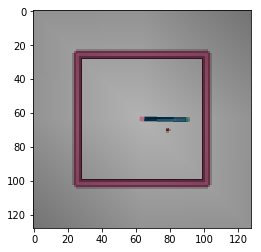

In [1]:
import gym
import random
import matplotlib.pyplot as plt
env = gym.make('Reacher-v101')
state = env.reset()
print(state.shape)
%matplotlib inline
plt.imshow(state)
plt.savefig('test.png')
plt.show()

# images = []
# for _ in range(10):
#     data = env.render(mode='rgb_array')
#     images.append(data)
# #     action = env.action_space.sample()
# #     actions = [[0.1, 0], [0,0.1]]
# #     action = random.choice(actions)
#     action = random.choice(env.action_space)
# #     print("Action: ", action)
#     env.step(action)
# env.close()
# print(data.shape)

In [5]:
len(images)

10

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (50,50))
for i in range(len(images)):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(images[i])
plt.show()
 
# plt.imshow(data, interpolation='nearest')

# w=10
# h=10
# fig=plt.figure(figsize=(8, 8))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()

NameError: name 'images' is not defined

<Figure size 3600x3600 with 0 Axes>